In [82]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile, assemble
from qiskit.circuit import ParameterVector
from qiskit_aer import Aer, AerSimulator
import math
from qiskit.quantum_info import Operator
import random
from qiskit_algorithms.optimizers import COBYLA
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit_algorithms.optimizers import SPSA

Construct the matrix A: QFT for n qubits

In [83]:
def qft_matrix(n):
    omega = np.exp(2 * np.pi * 1j / 2**n)
    return np.array([[omega**(i * j) / np.sqrt(2**n) for j in range(2**n)] for i in range(2**n)])

In [84]:
def create_ansatz(n, layers):
    qc = QuantumCircuit(n)
    params = ParameterVector('θ', length=layers * n * 2)
    idx = 0
    for _ in range(layers):
        for qubit in range(n):
            qc.ry(params[idx], qubit)
            idx += 1
        for qubit in range(n-1):
            qc.cx(qubit, qubit + 1)
        for qubit in range(n):
            qc.ry(params[idx], qubit)
            idx += 1
    return qc, params

In [85]:
def cost_function(params, ansatz, target_state, backend, shots=1024):
    bound_circuit = ansatz.assign_parameters(params)
    bound_circuit.measure_all()
    transpiled_qc = transpile(bound_circuit, backend)
    qobj = assemble(transpiled_qc, shots=shots)
    result = backend.run(qobj).result()
    counts = result.get_counts()
    # Normalize counts to get probabilities
    probabilities = {state: count / shots for state, count in counts.items()}
    target_counts = np.abs(target_state)**2
    error = sum((probabilities.get(bin(i)[2:].zfill(ansatz.num_qubits), 0) - target_counts[i])**2 for i in range(2**ansatz.num_qubits))
    return error

In [86]:
def train_ansatz(ansatz, target_state, backend, shots=1024, maxiter=100):
    initial_params = np.random.random(ansatz.num_parameters)
    history = {'params': [], 'cost': []}
    
    def callback(params):
        cost = cost_function(params, ansatz, target_state, backend, shots)
        history['params'].append(params)
        history['cost'].append(cost)
    
    result = minimize(cost_function, initial_params, args=(ansatz, target_state, backend, shots), method='COBYLA', callback=callback, options={'maxiter': maxiter})
    opt_params = result.x
    return opt_params, history

In [87]:
def iqft_matrix(n):
    return np.conj(qft_matrix(n).T)

def target_state(n):
    x = np.random.randint(0, 2**n)
    input_state = np.zeros(2**n)
    input_state[x] = 1
    return iqft_matrix(n) @ input_state

def compute_iqft_approximation(ansatz, params):
    bound_circuit = ansatz.assign_parameters(params)
    unitary = Operator(bound_circuit).data
    return unitary

def evaluate_accuracy_and_matrices(n_values, layers_values):
    backend = Aer.get_backend('qasm_simulator')
    accuracies_n = []
    matrices = []
    for n in n_values:
        print(f'n: {n}')
        accuracies = []
        target = target_state(n)
        for layers in layers_values:
            print(f'l: {layers}')
            ansatz, params = create_ansatz(n, layers)
            opt_params, history = train_ansatz(ansatz, target, backend)
            accuracy = 1 - history['cost'][-1] / sum(np.abs(target)**2)
            accuracies.append(accuracy)
            # Capture intermediate matrices for first few iterations
            intermediate_matrices = [compute_iqft_approximation(ansatz, p) for p in history['params'][:min(len(history['params']), 10)]]
            matrices.append(intermediate_matrices)
        accuracies_n.append(accuracies)
    return accuracies_n, matrices

n: 1
l: 1


C:\Users\ereld\AppData\Local\Temp\ipykernel_6044\2477107467.py:6: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = backend.run(qobj).result()


l: 2
l: 3
n: 2
l: 1
l: 2
l: 3
n: 4
l: 1
l: 2
l: 3
n: 8
l: 1
l: 2
l: 3


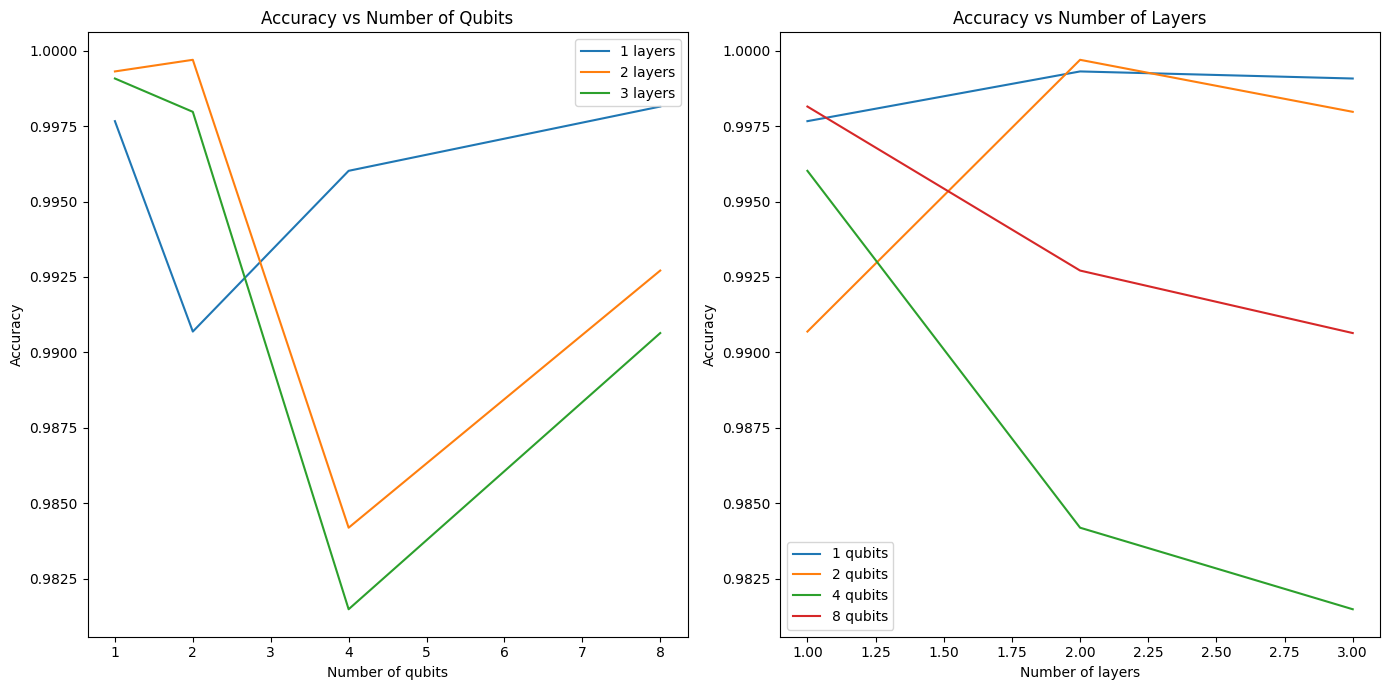

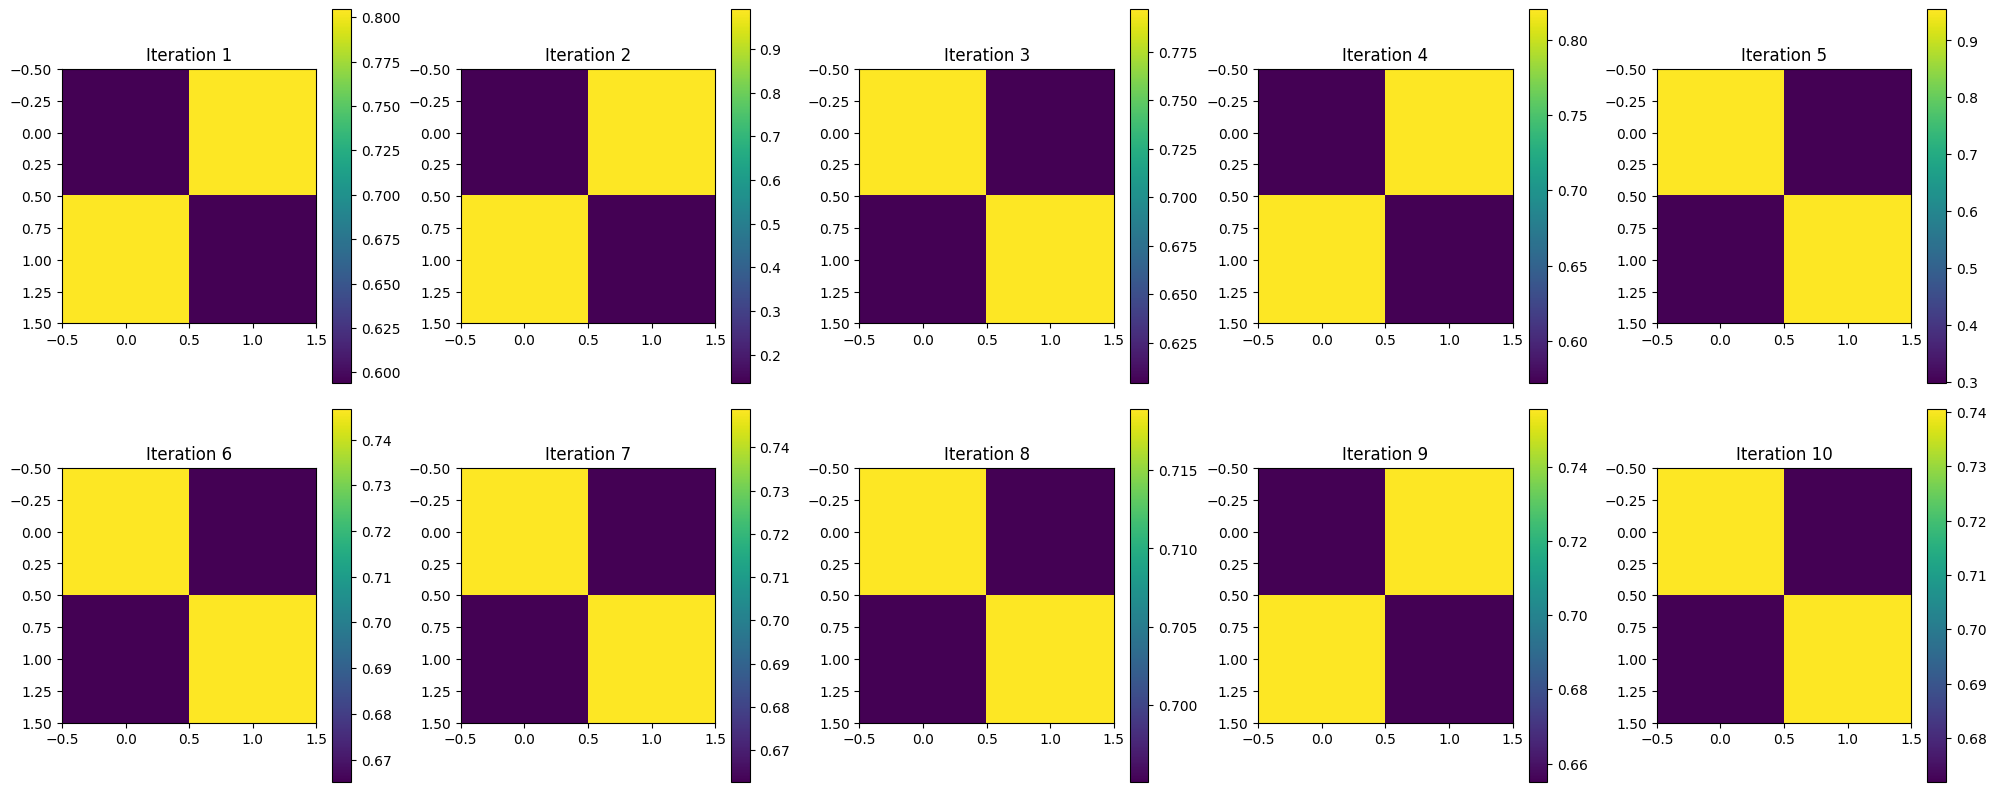

In [89]:
# Example usage:
n_values = [1, 2, 4, 8]  # Reduce the number of qubits for memory efficiency
layers_values = [1, 2, 3]

# Evaluate accuracy and capture matrices
accuracies_n, matrices = evaluate_accuracy_and_matrices(n_values, layers_values)

plt.figure(figsize=(14, 7))

# Accuracy as a function of the number of qubits
plt.subplot(1, 2, 1)
for i, layers in enumerate(layers_values):
    plt.plot(n_values, [accuracies_n[j][i] for j in range(len(n_values))], label=f'{layers} layers')
plt.xlabel('Number of qubits')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Qubits')
plt.legend()

# Accuracy as a function of the number of layers
plt.subplot(1, 2, 2)
for i, n in enumerate(n_values):
    plt.plot(layers_values, accuracies_n[i], label=f'{n} qubits')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Layers')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize the intermediate matrices for the first configuration
if matrices:
    plt.figure(figsize=(20, 20))
    for i, matrix_set in enumerate(matrices[0]):
        print(matrix_set)
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.abs(matrix_set), cmap='viridis')
        plt.colorbar()
        plt.title(f'Iteration {i + 1}')
    plt.tight_layout()
    plt.show()